# Using Python to analyse data on the coronavirus

Saeed Amen - https://www.cuemacro.com - saeed@cuemacro.com

First of all I want to stress that I am not a medic. However, I am a quant, and as such I wanted to see if there are simple ways I could look at the data related to the coronavirus. In particular, I'm doing some very simple plots and analysis, but I hope you find this code useful in any case (and feel free to copy and reuse). Our data source is one compiled by John Hopkins, which they've made available on GitHub at https://github.com/CSSEGISandData/COVID-19 and is being updated daily. This dataset drives a lot of analysis that has been published on the coronavirus. 

I've tried to stick to libraries which are relatively common like Pandas and like part of the standard Anaconda installation. If you want to use these notebooks in an easy to use way, I would recommend loading them on Azure Notebooks (http://notebooks.azure.com) which has a free version), and you can rerun as new data is released. If you want to setup your Python environment similar to mine follow the instructions at https://github.com/cuemacro/teaching/blob/master/pythoncourse/installation/installing_anaconda_and_pycharm.ipynb - this will pretty much install all the libraries you'll ever need for data science. I've also made a public Azure notebook version of this project at https://notebooks.azure.com/saeedamen/projects/coronavirus.

## Loading the data

We shall be looking at several CSV from the GitHub site which have time series number of confirmed cases, deaths and recovery cases related to COVID-19, and these are updated on a regular basis. Note, we are getting the raw content from these GitHub pages.

In [1]:
# Recently changed path
confirmed_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

# Note the recovered dataset is no longer being recovered
recovered_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

We'll also want to download some population data too from OECD, which has this path.

In [2]:
oecd_path = "https://stats.oecd.org/sdmx-json/data/DP_LIVE/.POP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en"

Let's do some imports of libraries and creation of objects we'll need to use later.

In [3]:
import pandas as pd

%matplotlib inline

Let's check my version of pandas. Mine is 0.24.2, but this notebook will likely work with other versions too.

In [4]:
pd.__version__

'0.24.2'

Let's load up all the datasets

In [5]:
df_confirmed = pd.read_csv(confirmed_path)
df_deaths = pd.read_csv(deaths_path)
# df_recovered = pd.read_csv(recovered_path) # Note: recovered dataset is not updated, so omitting

Check the format up of the downloaded data for the confirmed case.

In [6]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,176,183,186,189,197,212,212,259,267,276


We'll write a function to make the data easier to work with, transposing the dataset and making the date the index of our dataframe. We also add labels to the columns.

In [7]:
def aggregate_format_dataframe(df, label):
    # Replace some country labels to make them consistent for use later
    df['Country/Region'] = df['Country/Region'].replace('US', 'United States')
    df['Country/Region'] = df['Country/Region'].replace('Taiwan*', 'Taiwan')
    
    # Aggregate the figures by Country
    df = df.groupby(['Country/Region']).sum()
    
    df = df.transpose()
    
    # Strip first two lines (which has Lat/Long data)
    df = df[2:] 
    
    
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    original_columns = df.columns
    df.columns = [x + ' ' + label for x in df.columns]
    
    return df, original_columns

Let's run that function on our datasets.

In [8]:
df_confirmed_agg, confirmed_countries = aggregate_format_dataframe(df_confirmed, 'confirmed')
df_deaths_agg, deaths_countries = aggregate_format_dataframe(df_deaths, 'deaths')

# Note: recovered dataset is not updated so omitting
# df_recovered_agg, recovered_countries = aggregate_format_dataframe(df_recovered, 'recovered') 

countries = confirmed_countries

We can now see that dataset is in an easier to use format.

In [9]:
df_confirmed_agg.tail(5)

,Afghanistan confirmed,Albania confirmed,Algeria confirmed,Andorra confirmed,Angola confirmed,Antigua and Barbuda confirmed,Argentina confirmed,Armenia confirmed,Australia confirmed,Austria confirmed,...,United States confirmed,Uruguay confirmed,Uzbekistan confirmed,Venezuela confirmed,Vietnam confirmed,West Bank and Gaza confirmed,Western Sahara confirmed,Yemen confirmed,Zambia confirmed,Zimbabwe confirmed
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-25,30175.0,2192.0,12445.0,855.0,212.0,65.0,52457.0,22488.0,7595.0,17477.0,...,2422299.0,907.0,7177.0,4563.0,352.0,1382.0,10.0,1076.0,1497.0,551.0
2020-06-26,30451.0,2269.0,12685.0,855.0,212.0,65.0,55343.0,23247.0,7601.0,17522.0,...,2467554.0,919.0,7427.0,4779.0,353.0,1557.0,10.0,1089.0,1531.0,561.0
2020-06-27,30616.0,2330.0,12968.0,855.0,259.0,65.0,57744.0,23909.0,7686.0,17580.0,...,2510151.0,924.0,7682.0,5130.0,355.0,1815.0,10.0,1103.0,1531.0,567.0
2020-06-28,30967.0,2402.0,13273.0,855.0,267.0,69.0,59933.0,24645.0,7764.0,17654.0,...,2548996.0,929.0,7948.0,5297.0,355.0,1990.0,10.0,1118.0,1557.0,567.0
2020-06-29,31238.0,2466.0,13571.0,855.0,276.0,69.0,62268.0,25127.0,7834.0,17723.0,...,2590552.0,932.0,8222.0,5530.0,355.0,2185.0,10.0,1128.0,1568.0,574.0


## Plotting the cases data

We can try plotting confirmed cases in Italy and China.

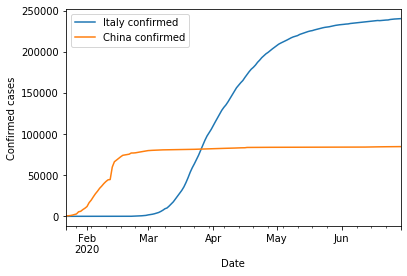

In [10]:
ax = df_confirmed_agg[['Italy confirmed', 'China confirmed']].plot()
ax.set_ylabel("Confirmed cases");

## Adjusting data by population

Obviously, it's difficult to compare these values, because of the differences in population. Let's download that data from OECD. We'll just pick up population data for 2014, the latest year available, and we strip down the dataframe, so it only has population values. Note, that this data isn't going to change often, so we can just cache it locally as a CSV.

In [11]:
import os

oecd_local_path = 'OECD.csv'

if os.path.exists(oecd_local_path):
    oecd_pop_df = pd.read_csv(oecd_local_path)
else:
    oecd_pop_df = pd.read_csv(oecd_path)
    oecd_pop_df.to_csv(oecd_local_path)

oecd_pop_df = oecd_pop_df[(oecd_pop_df['TIME'] == 2013) & (oecd_pop_df['SUBJECT'] == 'TOT') \
                              & (oecd_pop_df['MEASURE'] == 'MLN_PER')]
    
oecd_pop_df = pd.DataFrame(index=oecd_pop_df['LOCATION'].values, data=oecd_pop_df['Value'].values, columns=['Population'])
oecd_pop_df = oecd_pop_df.transpose()

If we look at the OECD data, it contains ISO codes, rather than the country names. We want to be able to convert the codes to country names, so we join it with our coronavirus dataset from earlier.

In [12]:
oecd_pop_df

,AUS,AUT,BEL,CAN,CZE,DNK,FIN,FRA,DEU,GRC,...,CRI,HRV,CYP,LTU,MLT,ROU,SAU,SGP,WLD,G20
Population,23.128129,8.47723,11.125033,35.082954,10.510719,5.608784,5.438975,65.735961,80.645605,10.965209,...,4.713168,4.254469,0.861938,2.957689,0.425966,19.988694,29.944476,3.844751,7213.426452,4632.240533


Let's now get the ISO codes from the various countries. We can get these from plotly express's in built gapminder datasets. Martien Lubberink has suggested the [pycountry library](https://pypi.org/project/pycountry/) which makes the whole process of getting ISO codes from countries much easier.

In [13]:
import plotly.express as px

iso_local_path = 'iso_code.csv'

if os.path.exists(iso_local_path):
    df_iso = pd.read_csv(iso_local_path)
else:
    df_iso = px.data.gapminder().query("year==2007")[['country', 'iso_alpha']]
    
    df_iso.index.name = 'code'

    # Relabel countries so the names match in the coronavirus dataset
    df_iso = df_iso.replace('Korea, Rep.', 'Korea, South')
    df_iso = df_iso.replace('Czech Republic', 'Czechia')
    df_iso = df_iso.replace('Slovak Republic', 'Slovakia')
    df_iso = df_iso[df_iso['country'] != 'Korea, Dem. Rep.']

    # Some countries are missing that we need to add 
    # https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
    extra_countries = [(170, 'Colombia', 'COL'),
    (376, 'Israel', 'ISR'),
    (643, 'Russia', 'RUS'),
    (233, 'Estonia', 'EST'),
    (442, 'Luxembourg', 'LUX'),
    (428, 'Latvia', 'LVA'),
    (440, 'Lithuania', 'LTU'),
    (196, 'Cyprus', 'CYP'),
    (470, 'Malta', 'MLT')]

    df_iso_extra = pd.DataFrame(data=extra_countries, columns=['code', 'country', 'iso_alpha'])
    df_iso_extra = df_iso_extra.set_index('code')
    
    df_iso = df_iso.append(df_iso_extra)
    
    df_iso.to_csv(iso_local_path)

Let's have a look at the ISO code dataset.

In [14]:
df_iso.head(5)

,code,country,iso_alpha
0,11,Afghanistan,AFG
1,23,Albania,ALB
2,35,Algeria,DZA
3,47,Angola,AGO
4,59,Argentina,ARG


We can replace the OECD ISO codes in the columns with the country names (with exceptions), so both datasets have matching names.

In [15]:
lst = []

for col in oecd_pop_df.columns:
    try:
        col = df_iso['country'][df_iso['iso_alpha'] == col].values[0]
    except:
        pass
    
    lst.append(col)

oecd_pop_df.columns = lst

We see we have relabelled the countries and also remove for example EU28 and OECD, given the coronavirus dataset doesn't have this data for aggregated grouping of countries. We also remove countries which are still in code format (ie. 3 letters long).

In [16]:
excluded_countries = ['EU28', 'G20', 'OECD', 'WLD']
oecd_countries = [x for x in oecd_pop_df.columns if x not in excluded_countries and len(x) > 3]
oecd_pop_df = oecd_pop_df[oecd_countries]

oecd_pop_df.columns

Index(['Australia', 'Austria', 'Belgium', 'Canada', 'Czechia', 'Denmark',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Japan', 'Korea, South', 'Luxembourg', 'Mexico',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
       'Slovakia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States', 'Brazil', 'Chile', 'Colombia',
       'Estonia', 'Israel', 'Russia', 'Slovenia', 'China', 'India',
       'Indonesia', 'South Africa', 'Latvia', 'Argentina', 'Bulgaria',
       'Costa Rica', 'Croatia', 'Cyprus', 'Lithuania', 'Malta', 'Romania',
       'Saudi Arabia', 'Singapore'],
      dtype='object')

Our dataset now only has the population values. One slight complication is that currency codes do not match our earlier datasets. The population of Italy is 60 million, whereas for China it is 1385 million. Admittedly this might be an simplistic comparison, given that most of the cases in China were in a specific area Hubei, which has a population of 58.5 million (from https://en.wikipedia.org/wiki/Hubei). Also for Italy most of the cases at the start of the episode have been in Northern Italy.

In [17]:
oecd_pop_df[['Italy', 'China']]

,Italy,China
Population,60.233944,1382.793212


Let's create a copy of the confirmed data and we'll then normalize the values by population for OECD countries where we have population data.

In [18]:
def normalize_data_by_pop(df, pop_df, label, countries_to_normalize):

    df = df.copy()

    for x in countries_to_normalize:
        df[x + ' ' + label] = df[x + ' ' + label].values / pop_df[x].values[0]
        
        
    return df
        
df_confirmed_oecd_normalized = normalize_data_by_pop(df_confirmed_agg, oecd_pop_df, 'confirmed', oecd_countries)
df_deaths_oecd_normalized = normalize_data_by_pop(df_deaths_agg, oecd_pop_df, 'deaths', oecd_countries)

If we plot the normalized figure for a few countries, the number of confirmed cases looks worse in Italy compared to China (but there are some caveats about Chinese data). Note also the different starting points, later on, we'll create functions, to adjust for the start of the outbreaks, to make the comparison more even.

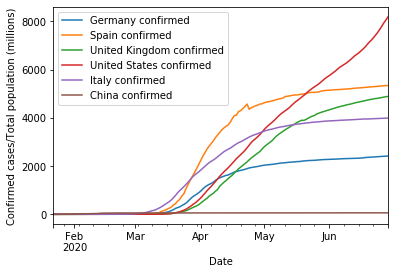

In [19]:
ax = df_confirmed_oecd_normalized[['Germany confirmed', 'Spain confirmed', 'United Kingdom confirmed', 'United States confirmed', 'Italy confirmed', 'China confirmed']].plot()
ax.set_ylabel("Confirmed cases/Total population (millions)");

Let's compare the total number of confirmed cases in Italy and the United Kingdom, which have relatively similar population levels. In this case we have shifted the UK values by 2 weeks. Thus far it seems as though the UK's confirmed cases is following the same pattern as Italy.

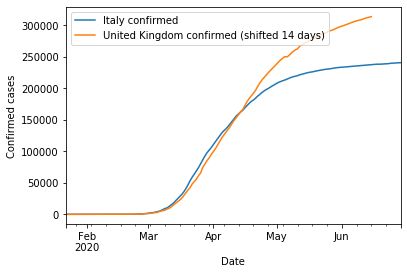

In [20]:
df_confirmed_agg_lag = df_confirmed_agg.copy()

df_confirmed_agg_lag['United Kingdom confirmed (shifted 14 days)'] = df_confirmed_agg_lag['United Kingdom confirmed'].shift(-14)
ax = df_confirmed_agg_lag[['Italy confirmed', 'United Kingdom confirmed (shifted 14 days)']].plot()
ax.set_ylabel("Confirmed cases");

Let's combine the confirmed cases with the deaths data, so we can compare the data.

In [21]:
df_confirmed_deaths_df = df_confirmed_agg.join(df_deaths_agg)

Let's plot it for Italy.

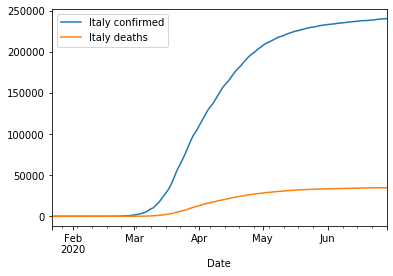

In [22]:
ax = df_confirmed_deaths_df[['Italy confirmed', 'Italy deaths']].plot()

## Adjusting confirmed cases by deaths

Next, we want to calculate the number of confirmed/death percentage. Note, for a large part of the sample this will be undefined for Italy (when there were no confirmed cases or deaths, which we shall label as zero).

In [23]:
countries_confirmed = [x + ' confirmed' for x in countries]
countries_deaths = [x + ' deaths' for x in countries]
countries_ratio = [x + ' deaths/confirmed' for x in countries]

perc = 100.0 * (df_deaths_agg[countries_deaths].values / df_confirmed_agg[countries_confirmed].values)

df_deaths_confirmed_perc = pd.DataFrame(index=df_deaths_agg.index, data=perc, columns=countries_ratio)
df_deaths_confirmed_perc = df_deaths_confirmed_perc.fillna(0) 

C:\Anaconda3\envs\py36class\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide



We can plot the percentages for China and Italy. For China it's been between 2-4%, although it appears higher in some sections of the time series in Italy. One reason can also be the number of tests conducted versus the overall population. As of March 3, 2020, [WHO reported](https://www.who.int/dg/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing-on-covid-19---3-march-2020) a figure of 3.4% globally.

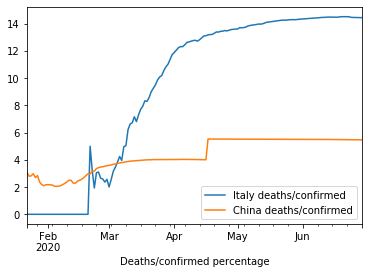

In [24]:
ax = df_deaths_confirmed_perc[['Italy deaths/confirmed', 'China deaths/confirmed']].plot()
ax.set_xlabel('Deaths/confirmed percentage');

Let's take the last available date for values, and then convert our DataFrame into tidy format (see https://cfss.uchicago.edu/notes/tidy-data/ for a description), which can be utilised more easily by certain Python libraries.

In [25]:
df_deaths_confirmed_perc_tidy = df_deaths_confirmed_perc.tail(1)
df_deaths_confirmed_perc_tidy.columns = [x.replace(' deaths/confirmed', '') for x in df_deaths_confirmed_perc_tidy.columns]
df_deaths_confirmed_perc_tidy = df_deaths_confirmed_perc_tidy.melt()
df_deaths_confirmed_perc_tidy.columns = ['country', 'deaths/confirmed perc']

import numpy as np
df_deaths_confirmed_perc_tidy = df_deaths_confirmed_perc_tidy.replace(0, np.nan)

Let's display the tidy DataFrame.

In [26]:
df_deaths_confirmed_perc_tidy.head(5)

,country,deaths/confirmed perc
0,Afghanistan,2.346501
1,Albania,2.351987
2,Algeria,6.668632
3,Andorra,6.081871
4,Angola,3.985507


## Plotting cases on a world map

We can now plot it using plotly express to create a world map using the death/confirmed ratio. But before we do that, we need to get the iso_codes for each country, which we got earlier from plotly express's in built gapminder datasets.

In [27]:
import plotly.express as px

df_deaths_confirmed_perc_tidy = df_deaths_confirmed_perc_tidy.merge(df_iso, on='country')

We now have a DataFrame with the additional iso_alpha column.

In [28]:
df_deaths_confirmed_perc_tidy.head(5)

,country,deaths/confirmed perc,code,iso_alpha
0,Afghanistan,2.346501,11,AFG
1,Albania,2.351987,23,ALB
2,Algeria,6.668632,35,DZA
3,Angola,3.985507,47,AGO
4,Argentina,2.055631,59,ARG


We can plot a world map of the death/confirmed percentages. Some might seem very high, because of a very small number of deaths and confirmed cases. Also have a look at https://covidlive.co.uk/ which has a live updated map for UK cases.

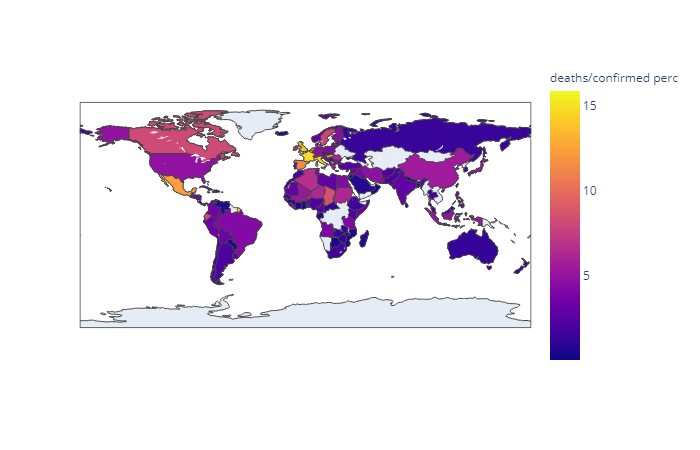

In [29]:
import plotly.io as pio
pio.renderers.default = "notebook" # make plots interactive (but will disappear when reopening notebook!)
# pio.renderers.default = "png" # static images

# You may need to change these paths
# pio.orca.config.executable = '/home/tcapyuser/anaconda3/envs/py36class/orca_app/orca'
# pio.orca.config.executable = 'C:/Anaconda3/envs/py36class/orca_app/orca.exe'

fig = px.choropleth(df_deaths_confirmed_perc_tidy, locations="iso_alpha",
                    color="deaths/confirmed perc", 
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

## Adjusting timelines by lags

Earlier, we showed some plots of UK and Italy, where the UK was lagged by 14 days, to take into account the relative starts of the outbreaks. Can we do this in a systematic way, rather than arbitrarily trying to pick a lag. One way to do this is to reindex our data, so that the timeline is automically shifted. The [FT](https://www.ft.com/coronavirus-latest) has produced some excellent visualisations based on shifts related to:

* confirmed cases are lagged by the number of days since 100th confirmed case related to the coronavirus
* deaths are lagged by the number of days since 10th death related to the coronavirus

We'll copy the same approach used by the FT, and other analysis based on this dataset. (Thanks Ewan Kirk for contributing to this!)

In [30]:
def timeline_lag(df, df_to_shift, rate): 
# Calculate based on df, but then shift in df_to_shift
# Eg. for normalized time series makes more sense to shift based on unnormalized

    df_to_shift = df_to_shift.copy()
    
    # Lag each column so it starts with the rate
    for col in df.columns.values:
        try:
            shift = df.index.get_loc(df[df[col] > rate].index[0])
        except IndexError:
            shift = df_confirmed.shape[0]

        df_to_shift[col] = df_to_shift[col].shift(-1*shift)
    
    df_to_shift['NumDays'] = range(0, df_to_shift.shape[0])
    df_to_shift.set_index('NumDays', inplace=True)
        
    return df_to_shift

df_confirmed_agg_lag_ft = timeline_lag(df_confirmed_agg, df_confirmed_agg, 100)
df_deaths_agg_lag_ft = timeline_lag(df_deaths_agg, df_deaths_agg, 10)

df_confirmed_oecd_normalized_lag_ft = timeline_lag(df_confirmed_agg, df_confirmed_oecd_normalized, 100)
df_deaths_oecd_normalized_lag_ft = timeline_lag(df_deaths_agg, df_deaths_oecd_normalized, 10)

Let's now plot the lagged time series by days since 100th confirmed case for a few countries.

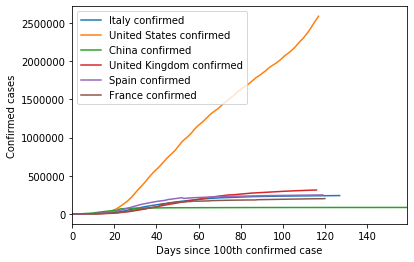

In [31]:
countries_to_plot = ['Italy', 'United States', 'China', 'United Kingdom', 'Spain', 'France']

ax = df_confirmed_agg_lag_ft[[x + ' confirmed' for x in countries_to_plot]].plot()
ax.set_ylabel("Confirmed cases");
ax.set_xlabel("Days since 100th confirmed case");

To do a log scale, we just need to add one line

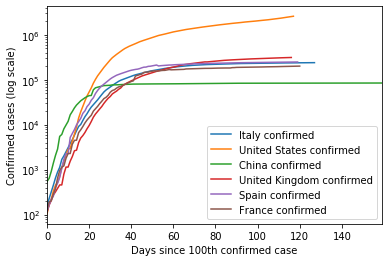

In [32]:
countries_to_plot = ['Italy', 'United States', 'China', 'United Kingdom', 'Spain', 'France']

ax = df_confirmed_agg_lag_ft[[x + ' confirmed' for x in countries_to_plot]].plot()
ax.set_yscale('log')
ax.set_ylabel("Confirmed cases (log scale)");
ax.set_xlabel("Days since 100th confirmed case");

We can also plot by confirmed cases/population.

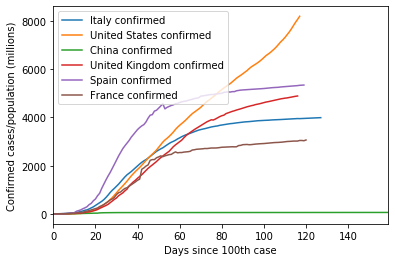

In [33]:
countries_to_plot = ['Italy', 'United States', 'China', 'United Kingdom', 'Spain', 'France']

ax = df_confirmed_oecd_normalized_lag_ft[[x + ' confirmed' for x in countries_to_plot]].plot()
ax.set_ylabel("Confirmed cases/population (millions)");
ax.set_xlabel("Days since 100th case");

## Interactive plots

We have created several DataFrame earlier, which should still be in memory, that are described below.

*  df_confirmed_agg - aggregated and rotated confirmed cases data
*  df_deaths_agg - aggregated and rotated deaths data
*  df_confirmed_oecd_normalized - normalised (by pop) confirmed cases data
*  df_deaths_oecd_normalized - normalised (by pop) deaths data

We need to remove the `confirmed` and `deaths` labels from the columns to make them easier to plot interactively.

In [34]:
def remove_label(df, label):
    df = df.copy()
    df.columns = [x.replace(' ' + label, '') for x in df.columns]
    
    return df

df_confirmed_agg_unlab = remove_label(df_confirmed_agg, 'confirmed')
df_deaths_agg_unlab = remove_label(df_deaths_agg, 'deaths')
df_confirmed_oecd_normalized_unlab = remove_label(df_confirmed_oecd_normalized, 'confirmed')
df_deaths_oecd_normalized_unlab = remove_label(df_deaths_oecd_normalized, 'deaths')

In [35]:
df_deaths_oecd_normalized_unlab.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United States', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', length=188)

In our earlier examples, we created static charts using Matplotlib. However, what if you want to make them interactive, so users can select the countries to examine? We can do that using ipywidgets, which allow us to create interactive sliders, radio buttons etc. in a Jupyter Notebook.

Thanks for Ewan Kirk for providing the code below for using ipywidgets (note, the widgets will only show up if you run the Jupyter notebook live). Note, that given we don't have population data for every country, the normalized data won't show up for every country.

In [36]:
import ipywidgets
import IPython

def display_cv_graph():
    ''' This is the function which does it all. I find using closures *very* helpful
        in Jupyter notebook.  Closures for functions and data help to stop the name space
        getting overwhelmed with junk and requiring cells to be executed in particular orders
        I also try to keep (almost) every variable outside the closures as a very small set
        of basic data variables.  And of course using UPPERCASE for defined constants
    '''
    def observer(values):
        # Clear the output.  This causes the graph to flash annoyingly.  There's a way to fix this but
        # it is pretty sophisticated so don't worry about it
        IPython.display.clear_output()
        
        # Display the controls
        IPython.display.display(controls)
        
        # Work out what to do
        do_confirmed = data_set.value is 'Confirmed'
        do_normalized = normalized.value is 'Yes'
        do_shifted = shifted.value is 'Yes'
        shift_limit = confirmed_shift.value if do_confirmed else deaths_shift.value
        
        if do_normalized:
            raw = df_confirmed_oecd_normalized_unlab if do_confirmed else df_deaths_oecd_normalized_unlab
        else:
            raw = df_confirmed_agg_unlab if do_confirmed else df_deaths_agg_unlab
            
        original_raw = df_confirmed_agg_unlab if do_confirmed else df_deaths_agg_unlab
            
        # Make a copy of the raw data frame and shift it if necessary
        df = raw.copy()
        
        # Do shift based on unnormalized data (otherwise units don't make sense)
        if do_shifted:
            for col in original_raw.columns.values:
                try:
                    shift = original_raw.index.get_loc(original_raw[original_raw[col] > shift_limit].index[0])
                except IndexError:
                    shift = original_raw.shape[0]
                    
                df[col] = raw[col].shift(-1 * shift)
                
            df['NumDays'] = range(0, df.shape[0])
            df.set_index('NumDays', inplace=True)
        
        if do_normalized:
            normalized_label = ' normalized by pop'
        else:
            normalized_label = ''
            
        # Setup the plot
        ax = df[list(countries.value)].plot(figsize=FIGSIZE)
        ax.set_ylabel(data_set.value + normalized_label)
        ax.set_yscale(log_lin.value.lower())
        if do_shifted:
            ax.set_xlabel("Number of days since {} {}".format(shift_limit, data_set.value))
        # and we are done so this function just waits for the next change
    
    # Construct controls
    log_lin = ipywidgets.RadioButtons(options=['linear', 'log'], description='Scale')
    countries = ipywidgets.SelectMultiple(options=df_confirmed_agg_unlab.columns.values,
                                          value=COUNTRIES, # Use the default countries
                                          rows=10,
                                          description='Countries')
    deaths_shift = ipywidgets.IntSlider(value=10, min=0, max=500, step=10, description='Deaths',
                                         continuous_update=False, orientation='vertical',
                                         readout=True, readout_format='d')
    confirmed_shift = ipywidgets.IntSlider(value=100, min=0, max=20000, step=100, description='Confirmed',
                                         continuous_update=False, orientation='vertical',
                                         readout=True, readout_format='d')
    data_set = ipywidgets.RadioButtons(options=['Confirmed', 'Deaths'],
                                      description='Data Set')
    shifted = ipywidgets.RadioButtons(options=['No', 'Yes'],
                                      description='Shifted')
    normalized = ipywidgets.RadioButtons(options=['No', 'Yes'],
                                      description='Normalized')
    controls = ipywidgets.HBox([countries, 
                                ipywidgets.VBox([data_set,
                                                 shifted,
                                                 normalized]),
                                log_lin,
                                deaths_shift,
                                confirmed_shift])
    
    # Make sure they're 'observed' for changes
    for widget in [data_set, shifted, log_lin, normalized, countries, deaths_shift, confirmed_shift]:
        widget.observe(observer, names='value')
        
    # Call the observer function to kick it all off
    observer(None)

Let's kick off the interactive widget and plot. Note, that we can change the default list of countries. We only have normalized data for those countries in the OECD (given our database for population data is only for OECD countries).

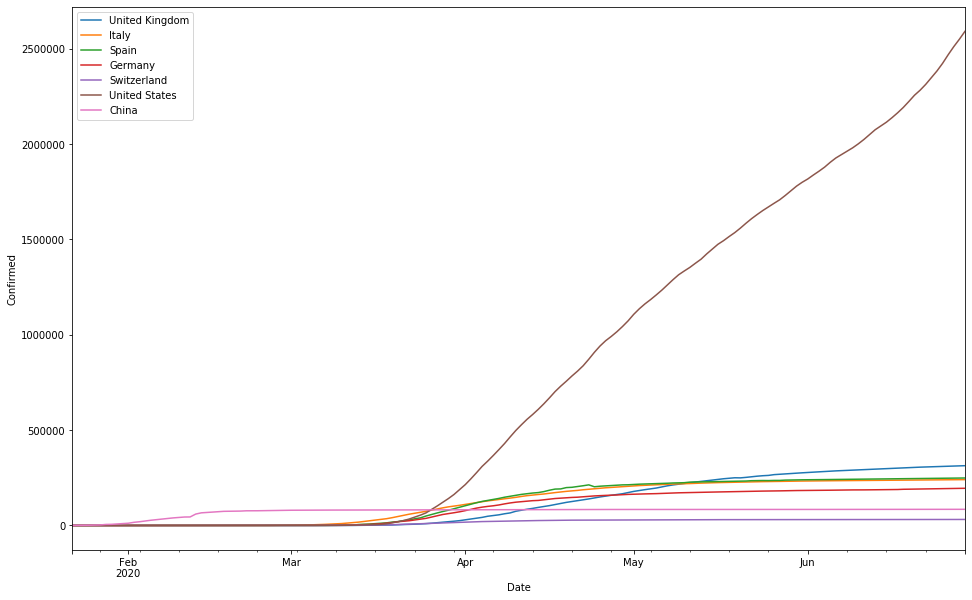

In [37]:
# Pick a good fig size
FIGSIZE=(16, 10)

COUNTRIES = ['United Kingdom', 'Italy', 'Spain', 'Germany', 'Switzerland', 'United States', 'China']

display_cv_graph()

# Change log

* 30 Jun 2020
    * Added orca path
* 23 Jun 2020
    * Added extra countries
* 12 Apr 2020
    * Added new confirmed/population plot
    * Various bug/label fixes
    * Updated data
* 28 Mar 2020
    * Added ipywidgets section
* 25 Mar 2020 
    * Updated to use new dataset location from https://github.com/CSSEGISandData/COVID-19/
    * Improved ISO country code joining
    * Added section on adjusting timelines
* 12 Mar 2020
    * First upload of coronavirus notebook